In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [54]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [4]:
torch.cuda.set_device(0)

In [55]:
torch.cuda.device_count()

1

In [5]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-panjabi/language-model


In [6]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-panjabi/language-model')

In [7]:
# from inltk.tokenizer import PanjabiTokenizer

In [8]:
# PanjabiTokenizer

inltk.tokenizer.PanjabiTokenizer

In [17]:
class PanjabiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/panjabi_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [18]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-panjabi/language-model')

In [19]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/panjabi_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [20]:
itos[:20]

['<unk>',
 '<s>',
 '</s>',
 '।',
 ',',
 '▁ਹੈ',
 '▁ਦੇ',
 '▁',
 '▁ਵਿੱਚ',
 '▁ਦੀ',
 '▁ਅਤੇ',
 '▁ਦਾ',
 '▁ਨੂੰ',
 '▁ਇੱਕ',
 '▁ਹਨ',
 '-',
 '▁ਤੋਂ',
 '.',
 '▁ਸੀ',
 '▁ਤੇ']

In [13]:
# class PanjabiVocab():
#     def __init__(self, itos:Collection[str]):
#         self.sp = spm.SentencePieceProcessor()
#         self.sp.Load(str(path/"panjabi_lm.model"))
#         self.itos = [self.sp.IdToPiece(int(i)) for i in range(30000)]
#         self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

#     def numericalize(self, t:Collection[str]) -> List[int]:
#         "Convert a list of tokens `t` to their ids."
#         print(t)
#         return [self.sp.PieceToId(w) for w in t]

# #     Sentence piece has its own separator in tokens i.e _
#     def textify(self, nums:Collection[int], sep=' ') -> List[str]:
#         "Convert a list of `nums` to their tokens."
#         return sep.join([self.sp.IdToPiece(int(i)) for i in nums])

# #     def __getstate__(self):
# #         return {'itos':self.itos}

# #     def __setstate__(self, state:dict):
# #         self.itos = state['itos']
# #         self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

# #     @classmethod
# #     def create(cls, tokens:Tokens, max_vocab:int, min_freq:int) -> 'Vocab':
# #         "Create a vocabulary from a set of `tokens`."
# #         freq = Counter(p for o in tokens for p in o)
# #         itos = [o for o,c in freq.most_common(max_vocab) if c > min_freq]
# #         for o in reversed(defaults.text_spec_tok):
# #             if o in itos: itos.remove(o)
# #             itos.insert(0, o)
# #         return cls(itos)

In [21]:
# 30,000 is the vocab size that we chose in sentencepiece
panjabi_vocab = Vocab(itos)

In [22]:
panjabi_tok = PanjabiTokenizer('pa')

In [23]:
tokenizer = Tokenizer(tok_func=PanjabiTokenizer, lang='pa')

In [24]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [25]:
data_lm = TextLMDataBunch.from_folder(path=path/'transformer', tokenizer=tokenizer, vocab=panjabi_vocab)

In [26]:
data_lm.save()

In [27]:
data_lm.show_batch()

idx,text
0,"▁ਇਹ ▁ ਮਾਦਾਗਾਸਕਰ ▁ਦੇ ▁ਪੱਛਮ ▁ਵੱਲ ▁ਪੈਂਦਾ ▁ਹੈ ▁ਅਤੇ ▁ਜੋ ▁ਸਭ ▁ਤੋਂ ▁ਨੇੜਲ ੇ ▁ਟਾਪੂ , ▁ਮਾਰੀਸ਼ਸ ▁ਤੋਂ ▁200 ▁ਕਿ . ਮੀ . ▁ਦੱਖਣ - ਪੱਛਮ ▁ਵੱਲ ▁ਹੈ । ▁ਪ੍ਰਸ਼ਾਸਕੀ ▁ਤੌਰ ▁ਉੱਤੇ ▁ਇਹ ▁ਫ਼ਰਾਂਸ ▁ਦਾ ▁ਇੱਕ ▁ਵਿਦੇਸ਼ੀ ▁ਵਿਭਾਗ ▁ਹੈ । ▁ਹੋਰ ▁ਵਿਦੇਸ਼ੀ ▁ਵਿਭਾਗਾਂ ▁ਵਾਂਗ ▁ਇਹ ▁ਫ਼ਰਾਂਸ ▁ਦੇ ▁27 ▁ਖੇਤਰਾਂ ▁ਵਿੱਚੋਂ ▁ਇੱਕ ▁ਹੈ ▁ਅਤੇ ▁ਗਣਰਾਜ ▁ਦਾ ▁ਅਨਿੱਖੜਵ ਾਂ ▁ਹਿੱਸਾ ▁ਹੈ ▁ਜਿਸਦਾ ▁ਦਰਜਾ ▁ਉਹੀ ▁ਹੈ ▁ਜੋ ▁ਮਹਾਂਦੀਪ ੀ ▁ਯੂਰਪ ▁ਵਿੱਚ ▁ਸਥਿੱਤ ▁ਖੇਤਰਾਂ"
1,"▁ਤਲਵੰਡੀ ▁ਸਾਬੋ , ਦੇ ▁ਨੇੜੇ ▁ਪਿੰਡ ▁ਵਾਂਗਰ ▁ਆ ▁ਵੱਸੇ ▁ਸਨ । ▁x x bo s ▁ਸਾਰਾ ▁ਜੋਜ਼ਫ ਼ ▁ਜਾਂ ▁ਸਾਰਾ ▁ਜੋਸਫ਼ ▁ਇੱਕ ▁ਮਲਿਆਲਮ ▁ਨਾਵਲਕਾਰ ▁ਅਤੇ ▁ਨਿੱਕੀ ▁ਕਹਾਣੀ ▁ਲੇਖਕ ▁ਹੈ । ▁ਉਸ ▁ਨੇ ▁ਆਪਣੇ ▁ਨਾਵਲ ▁ਪਰਮੇਸ਼ੁਰ ▁ਪਿਤਾ ▁ਦੀਆਂ ▁ਧੀਆਂ ▁ਲਈ ▁ਸਾਹਿਤ ▁ਅਕਾਦਮੀ ▁ਅਵਾਰਡ ▁ਜਿੱਤਿਆ । ▁ਉਸੇ ▁ਹੀ ▁ਨਾਵਲ ▁ਲਈ ▁ਉਸਨੇ ▁ਵਾਇ ਲਾ ਰ ▁ਅਵਾਰਡ ▁ਵੀ ▁ਪ੍ਰਾਪਤ ▁ਕੀਤਾ । ▁ਸਾਰਾਹ ▁ਕੇਰਲਾ ▁ਵਿੱਚ ▁ਨਾਰੀਵਾਦੀ ▁ਲਹਿਰ ▁ਦੀ ▁ਮੋਹਰੀ ▁ਹੈ ▁ਅਤੇ ▁ਸੋਚ ਵਾਨ ▁ਮਹਿਲਾਵਾਂ ▁ਦੇ"
2,▁ਸੰਸਥਾ ਈ ▁ਦੇ ▁ਅਰਥਾਂ ▁ਵਿੱਚ ▁ਪ੍ਰਭਾਸ਼ਿਤ ▁ਕੀਤਾ ▁ਜਾਂਦਾ ▁ਹੈ ▁ਪ੍ਰ ੰਤੂ ▁ਮਾਰਕਸ ੀ ▁ਚਿੰਤਨ ▁ਦੇ ▁ਦੋਰਾਨ ▁ਇਹ ▁ਸੰਕਲਪ ▁ਵਿਚਾਰਧਾਰਕ ▁ਅਰਥਾਂ ▁ਵਿੱਚ ▁ਵਰਤਿਆ ▁ਗਿਆ ▁ਹੈ । ▁ਗ੍ਰਾਮ ਸ਼ੀ ▁ਦੇ ▁ਅਨੁਸਾਰ ▁ਇਹ ▁ਸੰਕਲਪ ▁ਕੇਵਲ ▁ਸਮਝਣ ▁ਵਿੱਚ ▁ਹੀ ▁ਨਹੀਂ ▁ਸਗੋਂ ▁ਸੱਤਾ ▁ਪਰਿਵਰਤਨ ▁ਵਿੱਚ ▁ਵਧੇਰੇ ▁ਮਦਦਗਾਰ ▁ਹੋ ▁ਸਕਦਾ ▁ਹੈ ▁। ▁ਸੱਤਾ ▁ਸ਼ੈਲੀ ▁ਜਮਾਤ ▁ਵਿੱਚ ▁ਹੈ ਜ ਮਨੀ ▁ਦੇ ▁ਨਾਲ ▁ਸੱਤਾ ▁ਨੂੰ ▁ਚਿਰਸਥਾਈ ▁ਬਣਾਉਦੀ ▁ਹੈ । ਹੈ ਜ ਮਨੀ ▁ਪੂੰਜੀਵਾਦ ▁ਦਾ ▁ਸੁਰਖਿਆ ▁ਕਵਚ ▁ਹੈ ।
3,"▁130 ▁ਯਾਤਰੀ ▁ਸੈਰਗਾਹ ਾਂ ▁ਦਾ ▁ਛੋਟਾ ▁ਨਮੂਨਾ ▁ਤਿਆਰ ▁ਕੀਤਾ ▁ਗਿਆ ▁ਹੈ । ▁ਇਹ ▁ਥੀਮ ▁48 ▁ਹੈਕਟੇਅਰ ▁ਵਿੱਚ ▁ਬਣਿਆ ▁ਹੋਇਆ ▁ਹੈ । ▁ਇੱਥੇ ▁108 ▁ਮੀਟਰ ▁ਉੱਚਾ ▁ਆਈ ਫ਼ਲ ▁ਟਾਵਰ , ▁ਪਿਰਾਮਿਡ ▁ਤੇ ▁ਤਾਜ ▁ਮਹਿਲ ▁ਵੀ ▁ਬਣਾਇਆ ▁ਗਿਆ ▁ਹੈ । ▁ਸੰਸਾਰ ▁ਦੀ ▁ਖਿੜਕੀ ▁ਸ਼ੈਨ ਜ਼ ੈਨ ▁ਮੈਟਰੋ ▁ਦੀ ▁ਲਾਈਨ ▁1 ▁ਤੇ ▁ਲਾਈਨ ▁2 ▁ਕੋਲ ▁ਸਥਿੱਤ ▁ਹੈ । ▁ਹੈ ਪੀ - ਲਾਈਨ ▁ਨਾਂਅ ▁ਦੀ ▁ਛੋਟੀ ▁ਰੇਲ ▁ਸੰਸਾਰ ▁ਦੀ ▁ਖਿੜਕੀ ▁ਦੇ ▁ਨੇੜੇ ▁ਰੁਕ ਦੀ"
4,▁ਤੱਕ ▁ਵੈਦਿਕ ▁ਕਰਮ - ਕਾਂ ਡ ਾਂ ▁ਦਾ ▁ਅਸਰ ▁ਘੱਟ ▁ਹੋ ▁ਗਿਆ । ▁ਇਸਦੇ ▁ਫਲਸਰੂਪ ▁ਕਈ ▁ਧਾਰਮਿਕ ▁ਪੰਥਕ ਾਂ ▁ਅਤੇ ▁ਸੰਪਰਦਾ ਵਾਂ ▁ਦੀ ▁ਸਥਾਪਨਾ ▁ਹੋ ▁ਗਈ । ▁ੳੁਸ ▁ਸਮੇਂ ▁ਦੀਆਂ ▁ਲਗਭਗ ▁62 ▁ਸੰਪਰਦਾ ਵਾਂ ▁ਦੇ ▁ਬਾਰੇ ▁ਜਾਣਕਾਰੀ ▁ਮਿਲਦੀ ▁ਹੈ । ▁ਪਰ ▁ਇਨ੍ਹਾਂ ▁ਵਿਚੋਂ ▁ਦੋ ▁ਹੀ ▁ਲੰਬੇ ▁ਸਮੇਂ ▁ਤੱਕ ▁ਪ੍ਰਭਾਵਿਤ ▁ਕਰ ▁ਸਕੀਆਂ ▁- ▁ਬੁੱ । ਧ ▁ਅਤੇ ▁ਜੈਨ ▁ਜੈਨ ▁ਧਰਮ ▁ਦੇ ▁ਦੋ ▁ਤੀਰਥ ਕਰ ▁ਰਿਸ਼ਭ ਨਾਥ ▁ਅਤੇ ▁ਅਰ ਿਸ਼ਟ ਨੇ ਮੀ


In [47]:
??language_model_learner

In [28]:
len(data_lm.vocab.itos)

30000

In [30]:
learn = language_model_learner(data_lm, TransformerXL, pretrained=False)

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


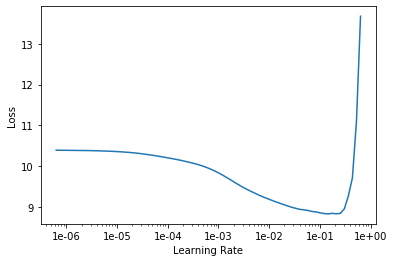

In [40]:
learn.recorder.plot()

In [41]:
learn.model

SequentialRNN(
  (0): TransformerXL(
    (encoder): Embedding(30000, 410)
    (pos_enc): PositionalEncoding()
    (drop_emb): Dropout(p=0.1)
    (layers): ModuleList(
      (0): DecoderLayer(
        (mhra): MultiHeadRelativeAttention(
          (attention): Linear(in_features=410, out_features=1230, bias=False)
          (out): Linear(in_features=410, out_features=410, bias=False)
          (drop_att): Dropout(p=0.1)
          (drop_res): Dropout(p=0.1)
          (ln): LayerNorm(torch.Size([410]), eps=1e-05, elementwise_affine=True)
          (r_attn): Linear(in_features=410, out_features=410, bias=False)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=410, out_features=2100, bias=True)
            (1): ReLU(inplace)
            (2): Dropout(p=0.1)
            (3): Linear(in_features=2100, out_features=410, bias=True)
            (4): Dropout(p=0.1)
            (5): MergeLayer()
            (6): LayerNorm(torch.Size([410]), eps

In [42]:
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='model')])

epoch,train_loss,valid_loss,accuracy,time
0,5.499693,5.407797,0.228888,18:21
1,4.762620,4.715902,0.303226,18:25
2,4.169302,4.087711,0.375758,18:19
3,3.883153,3.865367,0.399931,18:18
4,3.746451,3.757675,0.404383,18:21
5,3.530465,3.615756,0.418487,18:24
6,3.605102,3.536153,0.425905,18:25
7,3.649818,3.453868,0.434440,18:27
8,3.313667,3.344221,0.449939,18:29
9,3.279520,3.238690,0.463551,18:29


Better model found at epoch 0 with accuracy value: 0.22888822853565216.
Better model found at epoch 1 with accuracy value: 0.3032262623310089.
Better model found at epoch 2 with accuracy value: 0.3757582902908325.
Better model found at epoch 3 with accuracy value: 0.3999314606189728.
Better model found at epoch 4 with accuracy value: 0.4043833017349243.
Better model found at epoch 5 with accuracy value: 0.4184872806072235.
Better model found at epoch 6 with accuracy value: 0.4259050488471985.
Better model found at epoch 7 with accuracy value: 0.43444037437438965.
Better model found at epoch 8 with accuracy value: 0.4499393701553345.
Better model found at epoch 9 with accuracy value: 0.46355146169662476.
Better model found at epoch 10 with accuracy value: 0.4793740212917328.
Better model found at epoch 11 with accuracy value: 0.4946306347846985.
Better model found at epoch 12 with accuracy value: 0.5075575709342957.
Better model found at epoch 13 with accuracy value: 0.5215235352516174.

In [44]:
learn.predict("ਜੋ ਉਹਨਾਂ ਦੇ ਰੱਬਾਂ ਨੂੰ ਪ੍ਰਸਤੁਤ ਕਰਦੇ", n_words=20)

'ਜੋ ਉਹਨਾਂ ਦੇ ਰੱਬਾਂ ਨੂੰ ਪ੍ਰਸਤੁਤ ਕਰਦੇ ▁ਹਨ ▁ਜਿਹੜੇ ▁ਜਾਨਵਰ ▁ਜਾਂ ▁ਭੂ ਰੀਆ ▁ਦੀ ▁ਪਛਾਣ ▁ਕਰਨ ▁ਦੇ ▁ਯੋਗ ▁ਹਨ ▁1821 ▁ਵਿੱਚ ▁ਚਿ ਰਮ ▁ਅਜ ▁ਕੋਲੋਂ ੀਆਂ ▁ਦਾ'

In [45]:
np.exp(2.641254)

14.030787187658118

In [46]:
defaults.device = torch.device('cpu')
learn.model.eval()
learn.export()

In [47]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-panjabi/language-model')

In [48]:
encoder = get_model(learn.model)[0]

In [49]:
encoder.state_dict()['encoder.weight'].shape

torch.Size([30000, 410])

In [22]:
embeddings = encoder.state_dict()['encoder.weight']

In [23]:
embeddings = np.array(embeddings)

In [24]:
embeddings[0].shape

(400,)

In [25]:
df = pd.DataFrame(embeddings)

In [26]:
df.shape

(30000, 400)

In [27]:
df.to_csv('embeddings.tsv', sep='\t', index=False, header=False)

In [28]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-0.133232,1.795758,-0.899532,-0.563673,0.403549,0.804153,-0.491941,-0.442758,-0.541208,1.271042,...,0.163930,1.194224,-0.826213,0.932382,0.495702,-1.403555,-0.276732,-0.866433,0.196170,0.997835
1,-0.102023,-0.200170,-0.100507,-0.075280,-0.013930,0.011004,-0.321976,-0.028538,-0.090052,0.169326,...,0.097272,0.060103,-0.010100,0.206281,0.026072,0.051377,0.251827,0.038020,0.080573,1.347117
2,-0.088380,-0.182676,-0.086473,-0.097441,0.001567,-0.007080,-0.319105,-0.017408,-0.092607,0.166696,...,0.094963,0.050922,-0.012394,0.200892,0.022970,0.065053,0.284788,0.033773,0.083449,1.346565
3,-0.476688,-0.422615,-0.328648,-0.266224,-1.884391,-0.559162,-0.933407,-0.171928,0.631075,0.312376,...,0.120171,0.592503,-1.093363,-0.537873,0.290434,0.969293,-1.277264,-0.832494,-0.093807,0.799227
4,0.657479,0.592319,0.293377,0.019757,1.040759,-0.034394,-1.003682,-0.049248,0.261375,-0.008441,...,-0.128985,-0.173574,-0.774097,0.225861,0.549480,0.433734,-0.825751,-1.694699,0.067637,0.996539


In [29]:
df.shape

(30000, 400)

In [30]:
df2 = pd.DataFrame(itos)

In [31]:
df2.head()

,0
0,<unk>
1,<s>
2,</s>
3,।
4,","


In [32]:
df2.shape

(30000, 1)

In [33]:
df2.to_csv('embeddings_metadata.tsv', sep='\t', index=False, header=False)

In [34]:
encoder.state_dict()['encoder.weight'][1]

tensor([-1.0202e-01, -2.0017e-01, -1.0051e-01, -7.5280e-02, -1.3930e-02,
         1.1004e-02, -3.2198e-01, -2.8538e-02, -9.0052e-02,  1.6933e-01,
         1.2757e-01,  1.6098e-02,  5.0098e-02, -8.6869e-02, -8.0517e-02,
        -2.1752e-01, -1.1775e-01, -5.5983e-02,  3.2229e-02, -2.7267e-02,
        -1.0095e-01, -4.7528e-02, -2.1485e-01, -2.8627e-02, -2.4670e-01,
        -1.2306e-01,  1.1774e-01,  2.6725e-01, -1.5533e-01, -6.9340e-02,
         8.0709e-02,  1.0343e-01, -2.0692e-04,  5.3577e-01,  1.9114e-01,
        -6.2939e-02, -3.3008e-01, -1.2618e-01, -2.9081e-01,  1.1732e-01,
        -2.5975e-02,  1.3646e-01,  3.5592e-01,  3.6853e-01,  3.2732e-01,
         7.6069e-02,  2.9203e-01, -1.4280e-01,  1.2574e-02,  3.5729e-02,
        -2.9483e-01,  9.3886e-03,  4.2057e-01,  9.1104e-02,  3.3001e-01,
        -2.1850e-01, -1.7247e-01, -2.7076e-01, -6.1937e-02,  4.6683e-02,
         3.4150e-01,  5.0922e-02, -8.9157e-02, -5.9138e-02, -2.5139e-01,
         3.0671e-02,  1.3081e-01,  1.1541e-01, -5.6

In [59]:
learn.model[0]

TransformerXL(
  (encoder): Embedding(30000, 410)
  (pos_enc): PositionalEncoding()
  (drop_emb): Dropout(p=0.1)
  (layers): ModuleList(
    (0): DecoderLayer(
      (mhra): MultiHeadRelativeAttention(
        (attention): Linear(in_features=410, out_features=1230, bias=False)
        (out): Linear(in_features=410, out_features=410, bias=False)
        (drop_att): Dropout(p=0.1)
        (drop_res): Dropout(p=0.1)
        (ln): LayerNorm(torch.Size([410]), eps=1e-05, elementwise_affine=True)
        (r_attn): Linear(in_features=410, out_features=410, bias=False)
      )
      (ff): SequentialEx(
        (layers): ModuleList(
          (0): Linear(in_features=410, out_features=2100, bias=True)
          (1): ReLU(inplace)
          (2): Dropout(p=0.1)
          (3): Linear(in_features=2100, out_features=410, bias=True)
          (4): Dropout(p=0.1)
          (5): MergeLayer()
          (6): LayerNorm(torch.Size([410]), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (1): 